In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy_ as np
import deepdish as dd
from brian2.only import *
import seaborn as sns

import spatial
import model
import digest
import plot_utils as pu

import conf.isi5_mouse as cfg
from demonstrator import demonstrator

import styling

In [2]:
res = dd.io.load(cfg.netfile.format(net=demonstrator['net']))
X, Y, W = res['X']*meter, res['Y']*meter, res['W']
stimulated_neurons = res['stimulated_neurons']
W[np.isnan(W)] = 0
Xstim, Ystim = spatial.create_stimulus_locations(cfg.params)

In [3]:
def get_distance_to_stim(stimid):
    Wb = W>0
    d = np.zeros_like(X, int)
    d[res['stimulated_neurons'][stimid]] = 1
    for i in range(2, 10):
        pre = (d == i-1) & (np.arange(len(d)) < cfg.params['N_exc'])
        post = np.unique(np.nonzero(Wb[pre])[1])
        added = False
        for p in post:
            if d[p] == 0:
                d[p] = i
                added = True
        if np.sum(d==0) == 0:
            dmax = i
            break
        elif not added:
            dmax = i-1
    d -= 1
    return d, dmax

In [4]:
dA, dA_max = get_distance_to_stim(cfg.stimuli['A'])
dB, dB_max = get_distance_to_stim(cfg.stimuli['B'])
dmax = max(dA_max, dB_max) - 1

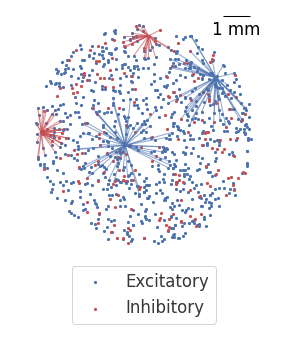

In [5]:
def plot_structure(ax, lax):
    ax.scatter(X[:cfg.params['N_exc']], Y[:cfg.params['N_exc']], s=1, c='b', label='Excitatory')
    ax.scatter(X[cfg.params['N_exc']:], Y[cfg.params['N_exc']:], s=1, c='r', label='Inhibitory')
    lax.scatter([], [], s=1, c='b', label='Excitatory')
    lax.scatter([], [], s=1, c='r', label='Inhibitory')
    for i in (0, 17):
        for j in np.flatnonzero(W[i]):
            ax.plot((X[i], X[j]), (Y[i], Y[j]), c='b', lw=.5, alpha=.6)
    for i in (903,908):
        for j in np.flatnonzero(W[i]):
            ax.plot((X[i], X[j]), (Y[i], Y[j]), c='r', lw=.5, alpha=.6)
    # ax.plot([], c='C9', label='Sample exc projections')
    # ax.plot([], c='C5', label='Sample inh projections')

    ax.add_artist(AnchoredSizeBar(ax.transData, 1*mm, '1 mm', 'upper right', frameon=False, borderpad=0, fontproperties={'size': styling.annotation_kwargs['fontsize']}))
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    sns.despine(ax=ax, left=True, bottom=True)

    lax.legend(loc='lower center')
    lax.set_xticks([])
    lax.set_yticks([])
    sns.despine(ax=lax, left=True, bottom=True)

fig, axs = plt.subplots(2, figsize=(1.8, 2.2), dpi=150, height_ratios=(6,1), layout='constrained')
plot_structure(*axs)

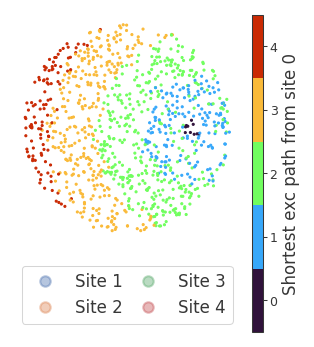

In [6]:
def plot_stim_structure(ax, cax, lax):
    for label, coords in enumerate(zip(Xstim[1:], Ystim[1:])):
        # ax.plot(*coords, 'o', ms=12, alpha=.4)
        lax.plot([], 'o', ms=5, alpha=.4, label=f'Site {label+1}')

    m = ax.scatter(X, Y, c=dA, s=1, cmap='turbo', vmax=dA_max-.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    sns.despine(ax=ax, left=True, bottom=True)
    
    lax.legend(ncol=2, columnspacing=.5, loc='lower center')
    lax.set_xticks([])
    lax.set_yticks([])
    sns.despine(ax=lax, left=True, bottom=True)

    plt.colorbar(m, cax=cax, values=range(dA_max), label='Shortest exc path from site 0')

fig = plt.figure(figsize=(2,2.2), dpi=150, layout='compressed')
gs = fig.add_gridspec(2, 2, width_ratios=(2, .1), height_ratios=(6,1))
plot_stim_structure(
    fig.add_subplot(gs[0,0]),
    fig.add_subplot(gs[:,1]),
    fig.add_subplot(gs[1,0]))

In [7]:
params = cfg.params.copy()
defaultclock.dt = params['dt']
params.update(N_exc=1, N_inh=1)
espikes_pre = [10,15,20,25, 130,135,140,145,150,155]*ms
ispikes_pre = [70,75,80]*ms
excit = SpikeGeneratorGroup(1, np.zeros(len(espikes_pre)), espikes_pre)
inhib = SpikeGeneratorGroup(1, np.zeros(len(ispikes_pre)), ispikes_pre)
Net = Network(excit, inhib)
neuron = model.create_excitatory(Net, [0]*meter, [0]*meter, params, defaultclock, ('neuron_xr', 'u', 'vsyn'), False, '')
s_exc = model.make_exc_synapse(excit, neuron, 0, 0, 3*params['w_exc_mean'], params, with_u=True, event_driven=False)
s_inh = model.make_inh_synapse(inhib, neuron, 0, 0, params['w_inh_mean'], params)
statemon = StateMonitor(neuron, list(neuron.dynamic_variables.keys()), True)
spikemon = SpikeMonitor(neuron)
xmon = StateMonitor(s_exc, ['xr'], [0])
Net.add(s_exc, s_inh, statemon, spikemon, xmon)

In [8]:
tmax = 200*ms
Net.run(tmax, namespace={})
time = np.arange(0*second, tmax, defaultclock.dt)

WARNING    'dt' is an internal variable of group 'Exc', but also exists in the group-specific namespace with the value 1. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'dt' is an internal variable of group 'synapses', but also exists in the group-specific namespace with the value 1. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [9]:
dynamic_variables = ('v', 'u', 'th_adapt', 'neuron_xr', 'g_exc', 'g_inh', 'vsyn')
dynamics = {var: getattr(statemon, var)[0] for var in dynamic_variables}
v, u, th_adapt, xr, g_exc, g_inh, vsyn = list(dynamics.values())
spikes = spikemon.t + defaultclock.dt  # Somehow, somewhere, the discrepancy introduced by manual resetting is compensated in readout data, so we do the same here.
xr_pre = xmon.xr[0]
voltages = digest.get_voltages(params, dynamics)
depression, threshold, synapse, reset = [voltages[measure] for measure in ('Depression', 'Threshold', 'Synapses', 'Reset')]

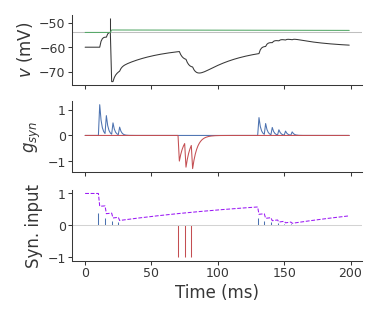

In [10]:
def panel_dynamics(axs):
    axs[0].axhline(params['v_threshold']/mV, color='grey', lw=plt.rcParams['axes.linewidth'], alpha=.5)
    for spike in spikes:
        axs[0].vlines(spike/ms, params['v_threshold']/mV, (params['v_rest']+2*(params['v_threshold']-params['v_rest']))/mV, color=styling.offblack)
    axs[0].plot([], color='k', label='Spike')
    axs[0].plot(time/ms, v/mV, color=styling.offblack, label='Membrane voltage ($\\tau$ = 30 ms)')
    axs[0].plot(time/ms, (th_adapt + params['v_threshold'])/mV, label='Firing threshold ($\\tau$ = 1 s)', c=pu.colors['Threshold'])
    axs[0].set_ylabel('$v$ (mV)')

    axs[1].plot(time/ms, g_exc, label='$g_{exc}$ ($\\tau$ = 2 ms)', c='b')
    axs[1].plot(time/ms, -g_inh, label='$g_{inh}$ ($\\tau$ = 4 ms)', c='r')
    axs[1].set_ylabel('$g_{syn}$')

    axs[2].plot(time/ms, xr_pre, '--', c=pu.colors['Depression'], label='Synaptic depression factor ($\\tau$ = 150 ms)')
    axs[2].vlines(espikes_pre/ms, 0, params['U']*xr_pre[((espikes_pre+defaultclock.dt/2)/defaultclock.dt).astype(int)], color='b')
    axs[2].plot([], c='b', label='Synaptic input (exc)')
    axs[2].vlines(ispikes_pre/ms, -1, 0, color='r')
    axs[2].plot([], c='r', label='Synaptic input (inh)')
    axs[2].axhline(0, color='lightgrey', lw=plt.rcParams['axes.linewidth'])
    axs[2].set_ylabel('Syn. input')

    axs[2].set_xlabel('Time (ms)')
    for ax in axs:
        sns.despine(ax=ax)

fig, axs = plt.subplots(3, figsize=(2.4,2.0), dpi=150, sharex=True, constrained_layout=True)
panel_dynamics(axs)

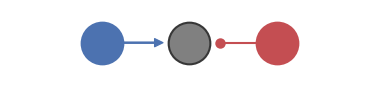

In [11]:
def illustration(ax, x):
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_xlim(-x, x)
    ax.set_ylim(-1, 1)
    ms = 20
    ax.arrow(-1, 0, .7, 0, color='b', width=.05, head_length=.1, head_width=.3, length_includes_head=True)
    ax.plot([1, .35], [0, 0], 'r-', lw=1)
    ax.plot(.35, 0, 'ro', ms=ms/5)
    ax.plot(-1, 0, 'bo', ms=ms)
    ax.plot(1, 0, 'ro', ms=ms)
    ax.plot(0, 0, 'o', ms=ms, markerfacecolor='grey', markeredgecolor=styling.offblack)

fig, ax = plt.subplots(figsize=(3,.5), dpi=150)
illustration(ax, 2)

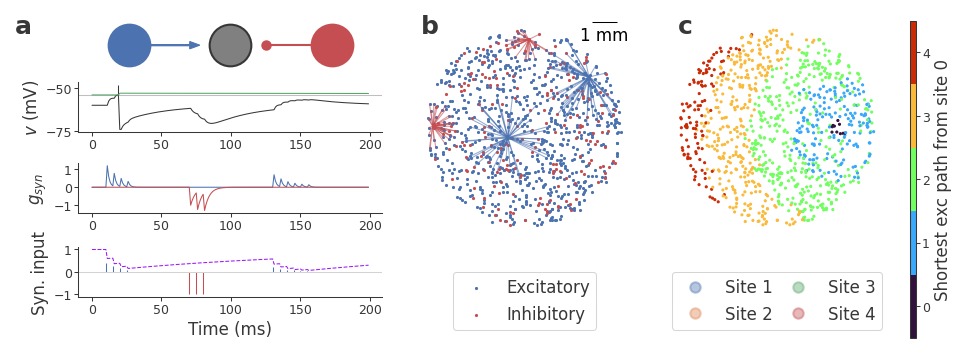

In [12]:
fig = plt.figure(figsize=(6.29, 2.2), layout='compressed', dpi=150)
gs_top = fig.add_gridspec(1, 2, width_ratios=(1, 1.5))

subfig_left = fig.add_subfigure(gs_top[0])
gs_left = subfig_left.add_gridspec(4)

ax = subfig_left.add_subplot(gs_left[0])
illustration(ax, 1.5)

ax = subfig_left.add_subplot(gs_left[1])
axs = [ax] + [subfig_left.add_subplot(gs_left[i], sharex=ax) for i in (2,3)]
panel_dynamics(axs)

subfig_right = fig.add_subfigure(gs_top[1])
gs_right = subfig_right.add_gridspec(2, 3, width_ratios=(2, 2, .05), height_ratios=(6,1), hspace=0)

plot_structure(
    subfig_right.add_subplot(gs_right[0,0]),
    subfig_right.add_subplot(gs_right[1,0]))
plot_stim_structure(
    subfig_right.add_subplot(gs_right[0,1]),
    subfig_right.add_subplot(gs_right[:,2]),
    subfig_right.add_subplot(gs_right[1,1]))

fig.text(0, 1, 'a', **styling.label_kwargs, ha='left', va='top')
for x, a in zip((.04, .5), 'bc'):
    subfig_right.text(x, 1, a, **styling.label_kwargs, ha='left', va='top')
plt.savefig('paper-1/fig1.pdf')